___

Gender Classification 


Computer  Vision


AlexNet

___

### Gender Classification

In this notebook we are going to create a Neural Network for a computer vision task that will do gender classification using the [`AlexNet`](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) like achitecture. We are going to load images and their lables using the `datasets.ImageFolder` and apply some torch vision transforms.


### Data
We will be loading the data from my google drive that I've uploaded. We have a `zipfile` named `gender.zip`. We are going to extract it and then load the data using the `datasets.ImageFolder`.


### Mounting the drive

Since I will be loading the images from my google drive we need to mount the google drive. In the following code cell we are going to mount the drive.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### Unzipping the gender.zip folder

In [ ]:
import zipfile, os, time

base_path = "/content/drive/My Drive/Computer Vision"
zip_folder = os.path.join(base_path, "gender.zip")
out_dir = os.path.join(base_path, "gender")

if os.path.exists(out_dir):
  print("already exists...")
else:
  os.mkdir(out_dir)
  with zipfile.ZipFile(zip_folder, 'r') as ref:
    ref.extractall(out_dir)
  print("Done")

already exists...


### Folder structure

After extracting the the `gender.zip` file we are going to have the following folder stucture:

```
📁 genders
    📁 Training
        📁 female
            - image.png
            ....
        📁 male
            - image.png
            ....
    📁 Validation
        📁 female
            - image.png
            ....
        📁 male
           - image.png
           ....

```

Our goal is to use the `datasets.ImageFolder` to read all these images in the train and validation directories and create dataloaders. Note that we are also going to come up with the test set from these sets as well. We are going to use [one of my previous notebook](https://github.com/CrispenGari/pytorch-python/blob/main/03_Torch_Vision/02_ImageFolder/01_ImageFolder_%2Band_DataLoader.ipynb) as reference to the part of creating the datasets from ``ImageFolder``.

### Creating a test folder

We need to create a test folder that will come with 2 classes, `male` and `female`. So we are going to exapand the directory structure to be something like

```
📁 genders
    📁 Testing
        📁 female
            - image.png
            ....
        📁 male
            - image.png
            ....
    .....
```

We are going to take only `.05` fraction from the train set.

In [ ]:
import shutil

In [ ]:
training_males = os.listdir(os.path.join(out_dir, "Training/male"))
training_females = os.listdir(os.path.join(out_dir, "Training/female"))

KeyboardInterrupt: ignored

In [ ]:
training_males[:2], training_females[:2]

In [ ]:
test_fraction = .05
test_samples_male = int(len(training_males) * test_fraction)
test_samples_female = int(len(training_females) * test_fraction)


test_dir = os.path.join(out_dir, "Testing")
test_male = os.path.join(test_dir, "male")
test_female = os.path.join(test_dir, "female")

if not os.path.exists(test_dir):
  os.mkdir(test_dir)

if not os.path.exists(test_male):
  os.mkdir(test_male)

if not os.path.exists(test_female):
  os.mkdir(test_female)


...Moving the images to their respective folders


⚠: _We only need to run the following code cell once, otherwise we will keep on moving images from the train to the test until the train folder is empty_.

In [ ]:
# for img_name in training_males[:test_samples_male]:
#   shutil.move(os.path.join(out_dir, "Training", "male", img_name), os.path.join(test_male))

# for img_name in training_females[:test_samples_female]:
#   shutil.move(os.path.join(out_dir, "Training", "female", img_name), os.path.join(test_female))

# print("Done")

In [ ]:
import torch, random
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt

torch.__version__

'1.10.0+cu111'

### Seeds

Setting the seeds

In [ ]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device

Using the `gpu` if possible.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Normalizing the dataset

_The idea of data normalization is an general concept that refers to the act of transforming the original values of a dataset to new values._ - **deeplizard**


We use normalization for feature scalling. Standadization is an example of normalization it is sometimes called `z-score normalization`. So we need to normalize our dataset but first of all we need to calculate the mean and starndard deviations for each chanels in the training set so that when we call the `transforms.Normalize()` we pass the mean and standard deviations for each channel


```py
torchvision.transforms.Normalize(
      [meanOfChannel1, meanOfChannel2, meanOfChannel3] 
    , [stdOfChannel1, stdOfChannel2, stdOfChannel3] 
)
```

So which means we need to manually with code calculate the `means` and `std` values for each channel in our train set. 

In [ ]:
os.listdir(out_dir)

In [ ]:
train_data = datasets.ImageFolder(
    os.path.join(out_dir, "Training"),
    transform=transforms.Compose([
        transforms.Resize([224, 224]), # alenet image size
        transforms.ToTensor() # so that we will be able to calculate mean and std
    ])
)

### Data Argumentation

We are going to apply some data argumentations on or train and test sets. But remember we only have train and validation set, so where are we going to get the test set? 


We are going to take  afraction from the train dataset and then change the tranforms of the test set later on and apply the validation transforms.


Note that on the test and validation transforms we are only going to apply `ToTensor()` and `Normalize()` transforms.


In [ ]:
means = stds = [.5, .5, .5]

In [ ]:
image_transforms = {
    "training": transforms.Compose([
       transforms.Resize([224,224]),
       transforms.RandomRotation(5),
       transforms.RandomHorizontalFlip(.5),
      #  transforms.RandomCrop(32, padding=2),
       transforms.ToTensor(),
       transforms.Normalize(mean=means, std=stds, inplace=False)                         
    ]),
    "validation": transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=means, std=stds, inplace=False)
    ]),
    "testing": transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=means, std=stds, inplace=False)
    ])
}

In [ ]:
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(out_dir, x.capitalize()),
        transform = image_transforms[x]
    ) for x in ["training", 'validation', 'testing']
}

### Getting the classes



In [ ]:
class_names = image_datasets["training"].classes
class_names

['female', 'male']

In [ ]:
image_datasets["training"][0][0].shape

torch.Size([3, 224, 224])

In [ ]:
train_data = image_datasets["training"]
val_data = image_datasets["validation"]
test_data = image_datasets["testing"]

In [ ]:
test_data[0][0].shape

torch.Size([3, 224, 224])

### Counting examples

Next we are going to count examples for each set.

In [ ]:
from prettytable import PrettyTable

def tabulate(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

In [ ]:
title = "DATASETS EXAMPLES"
columns = "SET", "TOTAL"
data_rows = ("training", len(train_data)), ("testing", len(test_data)), ("validation", len(val_data))
tabulate(columns, data_rows, title)


+--------------------+
| DATASETS EXAMPLES  |
+------------+-------+
| SET        | TOTAL |
+------------+-------+
| training   | 44659 |
| testing    |  2350 |
| validation | 11649 |
+------------+-------+


### Visualizing some faces

We are going to create a helper function that will visualize the images and normalize them by clipping the values to be in range [0, 1].

Note: torchvision handles images that are arranged `[channel, height, width]` and matplotlib handles images `[height, width, channels]` so we will need to pemute them so that they can be visualized using matplotlib.

In [ ]:
def plot_images(images, labels, classes, normalize=False):
  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize = (8, 8))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image = images[i]
    
    if normalize:
      image_min = image.min()
      image_max = image.max()
      image.clamp_(min=image_min, max=image_max)
      image.add_(-image_min).div_(image_max - image_min + 1e-5)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')

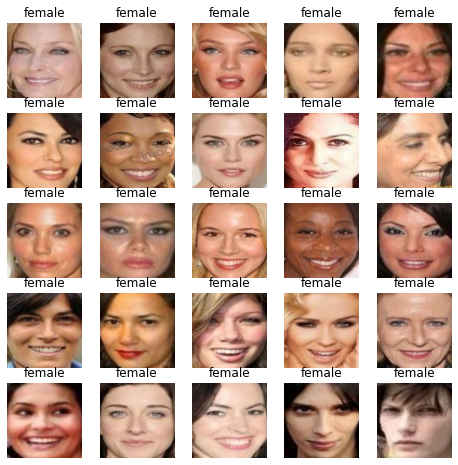

In [ ]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])
classes = train_data.classes
plot_images(images, labels, classes, True)

We are also going to create another helper function `normalize_image` that will normalize the image for us and return the image.

In [ ]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min=image_min, max=image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

### Iterators

The final step of data processing is creating iterators. We are going to shuffle all the images in the three sets, it doesn't mater which set do they belong to: 

Note: _In the validation and test dataset we normally don't shuffle them._

In [ ]:
BATCH_SIZE = 256

train_iterator = data.DataLoader(
    train_data, shuffle=True, batch_size= BATCH_SIZE, numnum_workers=5, pin_memory=True
)

valid_iterator = data.DataLoader(
    val_data, batch_size= BATCH_SIZE, shuffle=True, numnum_workers=5, pin_memory=True
)

test_iterator = data.DataLoader(
    test_data,  batch_size= BATCH_SIZE, shuffle=True, numnum_workers=5, pin_memory=True
)

TypeError: ignored

### The `LNet` model

Our model will have two parts:

1. `features`
2. `classfier`

The features and classifier are two `nn.Sequential` models that will be connected to each other.

Calculating the output width

```
output_width = (image_width - kernel_size + 1)/ pool_size
```

The image size that I have:

```
width = 224
height = 224
in_channels = 3
```





In [ ]:
( 5- 3 + 1)/2

1.5

In [ ]:
IMG_WIDTH = IMG_HEIGHT = 224

class AlexNet(nn.Module):
  def __init__(self, output_dim):
    super(AlexNet, self).__init__()
    self._to_linear = None
    self.x = torch.randn(3, IMG_WIDTH, IMG_HEIGHT).view(-1, 3, IMG_WIDTH, IMG_HEIGHT)
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, 3, 2, 1), # in_channels, out_channels, kernel_size, stride, padding
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 192, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True), 
        nn.Conv2d(192, 384, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 512, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 256, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True)
  )
    self.conv(self.x)
    self.classifier = nn.Sequential(
        nn.Dropout(.5),
        nn.Linear(self._to_linear, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, output_dim),
    )

  def conv(self, x):
    x = self.features(x)
    if self._to_linear is None:
      self._to_linear = x.shape[1] * x.shape[2] * x.shape[3]
    return x

  def forward(self, x):
    x = self.conv(x)
    h = x.view(x.shape[0], -1)
    x = self.classifier(h)
    return x, h


In [ ]:
OUTPUT_DIM = 1

model = AlexNet(OUTPUT_DIM).to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU(inplace=True)
    (9): Conv2d(384, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=12544

### Counting model parameters.

Our model has `~30M` parameters.

In [ ]:
def count_params(model):
  total_params = sum([p.numel() for p in model.parameters()])
  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  tabulate(["","Parameters"], 
           [["total parameters", f'{total_params:,}'],
            ["trainable parameters", f'{trainable_params:,}']],
           "MODEL PARAMETERS"
           )
count_params(model)


+-----------------------------------+
|          MODEL PARAMETERS         |
+----------------------+------------+
|                      | Parameters |
+----------------------+------------+
| total parameters     | 71,896,129 |
| trainable parameters | 71,896,129 |
+----------------------+------------+


### Initializing model parameters



In [ ]:
def initialize_parameters(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight.data, nonlinearity="relu")
  elif isinstance(m, nn.Linear):
    nn.init.xavier_normal_(m.weight.data, gain= nn.init.calculate_gain('relu')
    )
    nn.init.constant_(m.bias.data, 0)
    

In [ ]:
model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU(inplace=True)
    (9): Conv2d(384, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=12544

### The accuracy function.

We are going to create a binary accuracy helper function that does the calculation of accuracy for us.

In [ ]:
def binary_accuracy(y_preds, y_true):
  rounded_preds = torch.round(torch.sigmoid(y_preds))
  correct = (rounded_preds == y_true).float()
  return correct.sum() / len(correct)

### Loss and Optimizer

Since this is a binary classification task we are goig to use the `BCEWithLogitsLoss()` and we are going to use `Adam()` as our optimizer with default parameters.

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss().to(device)

### Train and Evaluate functions.

1. train

* first we put the model in the train mode by calling the `model.train()`
* We will iterate over the iterator and put labels and features(images) to the `device`
* we call the `optimizer.zero_grad()` to restore the gradients of the optimizer for each iteration
* we make predictions and calculate the accuracy and loss
* we then updates the weights by calling `optimizer.step()` after backward propergation using the `loss.backward()`
* we will return the loss and the accuracy 

2. evaluate

* we put the model in evaluation mode'
* we wrap our loop with `torch.no_grad()` beacuse we are not interested in calculating the gradients during model evaluation.
* We calculate the loss and accuracy and return them


Our train and evaluate function are as follows:



In [ ]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device).float()
    # Zero the gradients
    optimizer.zero_grad()
    y_pred, _ = model(x)
  
    # Calculate the loss and accuracy
    loss = criterion(y_pred.squeeze(), y)
    acc = binary_accuracy(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()

    epoch_loss +=loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device).float()
      y_pred, _ = model(x)
      loss = criterion(y_pred.squeeze(), y)
      acc = binary_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)


### Training the mode

We are going to have some helper function that we are going to use to visualize our training.

1. a function that tabulates the training

2. a function that convert time to a nice looking string representation

In [ ]:
def hms_string(sec_elapsed):
  h = int(sec_elapsed / (60 * 60))
  m = int((sec_elapsed % (60 * 60)) / 60)
  s = sec_elapsed % 60
  return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
def tabulate_training(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  table.align[column_names[2]] = 'r'
  table.align[column_names[3]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

In [ ]:
EPOCHS = 10
MODEL_NAME = "gender-classifier.pt"
best_valid_loss = float('inf')
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
for epoch in range(EPOCHS):
  start = time.time()
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), MODEL_NAME)
  end = time.time()

  data_rows = [
      ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
      ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
  ]
  title = f"EPOCH {epoch+1:02}/{EPOCHS} {'(saved)' if valid_loss < best_valid_loss else '(not saved)' }"
  tabulate_training(column_names, data_rows, title)


RuntimeError: ignored

### Evaluating the best model


In [ ]:
model.load_state_dict(torch.load(MODEL_NAME))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tabulate_training(column_names, data_rows, title)
